In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pyreadr
import itertools
import sys
import xarray as xr
import multiprocessing as mp

In [2]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, float(1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [3]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

In [4]:
def abc_ext_func(h, model, r, s):
    length = len(r)
    abc_ext = 0
    for i in range(length):
        abc_ext += extremal_coefficient(h, model, r[i], s[i])
    abc_ext = abc_ext / length
    return(abc_ext)

In [5]:
def abc_error_function(h, model, r_true, s_true, r, s):
    error = np.power(extremal_coefficient(h, model, r_true, s_true) - abc_ext_func(h, model, r, s),2)
    return error

In [6]:
def get_imse(model, true_params, abc_params):
    r_true, s_true = true_params
    r, s, = abc_params
    error, _ = quad(abc_error_function, 0, 40, args = (model, r_true, s_true, r, s))
    return error

In [7]:
def get_abc_metrics(true_params, abc_params, model):
    abc_array = np.array(abc_params)
    abc_mean = np.transpose(abc_array.mean(axis = 2))
    rmse = np.sqrt(np.mean((np.power(abc_mean - true_params,2)), axis = 0))
    imse_ext = np.mean(np.array([get_imse(model, true_params[i], abc_array[:,i]) for i in range(true_params.shape[0])]))
    
    
    print(f"RMSE: {np.round(rmse,2)}") 
    print(f"Ext - IMSE: {np.round(imse_ext,4)}")

In [8]:
def interval_score(
    observations,
    alpha,
    q_left=None,
    q_right=None,
):

    sharpness = q_right - q_left
    calibration = (
        (
            np.clip(q_left - observations, a_min=0, a_max=None)
            + np.clip(observations - q_right, a_min=0, a_max=None)
        )
        * 2
        / alpha
    )
    total = sharpness + calibration
    return total, sharpness, calibration

In [9]:
exp = "exp_5"
path = f'../data/{exp}/data/'
model = "powexp"
brown_params = pyreadr.read_r(path+model+"_test_params.RData")["test_params"].to_numpy()

path = f'../data/{exp}/results/'

In [10]:
brown_res = xr.open_dataset(path+model+"_abc_samples_interpolated_6.nc")

In [11]:
test_samples = brown_res.Range.shape[0]
test_parameters = brown_params[0:test_samples]

In [12]:
#Define abc sample arrays
r = brown_res.Range.to_numpy()
s = brown_res.Smoothness.to_numpy()

In [13]:
# Get metrics
get_abc_metrics(test_parameters, [r,s], model)

RMSE: [3.78 0.55]
Ext - IMSE: 0.0827


In [14]:
# Evaluate interval
r_lower, r_upper = np.quantile(r, [0.025,0.975], axis = 1)
s_lower, s_upper = np.quantile(s, [0.025,0.975], axis = 1)

In [15]:
r_coverage = np.sum((test_parameters[:,0] >= r_lower) & ((test_parameters[:,0] <= r_upper)))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >=s_lower) & ((test_parameters[:,1] <= s_upper)))/test_samples*100

In [16]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, r_lower, r_upper)
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, s_lower, s_upper)
s_is = np.mean(s_is)

In [17]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: powexp
Coverage 86.00%, 98.00% 
IS: 10.4670, 1.8585


## Plot

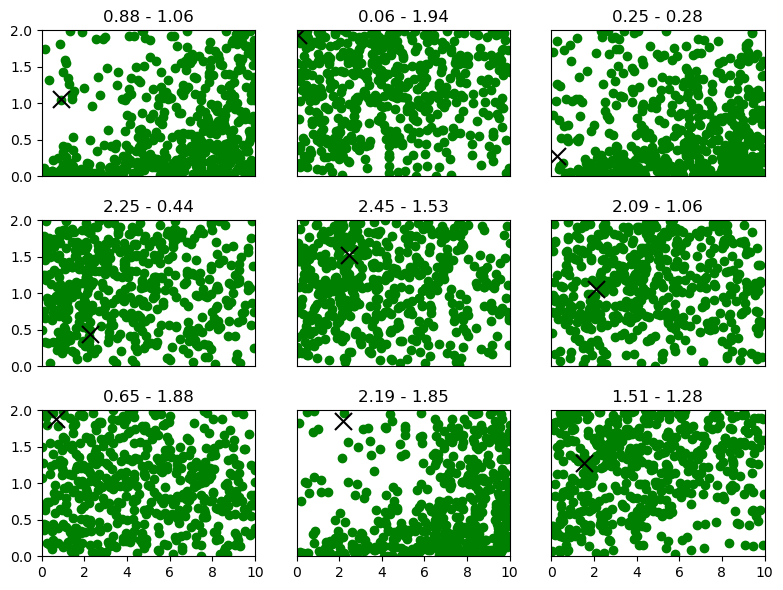

In [24]:
fig, axs = plt.subplots(3,3,figsize = (8,6))
axs = axs.ravel()
samples = np.random.randint(0,test_samples,9)
for i, sample in enumerate(samples):
    axs[i].scatter(x = brown_res.Range[sample], y = brown_res.Smoothness[sample], color = "green")
    axs[i].scatter(x = test_parameters[sample,0], y = test_parameters[sample,1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{test_parameters[sample,0]:.2f} - {test_parameters[sample,1]:.2f}")   
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0,10])
    if i < 6:
        axs[i].get_xaxis().set_visible(False)
    if (i%3) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

# Compare

In [70]:
i = 5

In [71]:
x = np.linspace(0,40,400)
model = "brown"
corr_true = extremal_coefficient(x, model, test_parameters[i,0], test_parameters[i,1])
corr_abc = abc_ext_func(x, model, r[i], s[i])

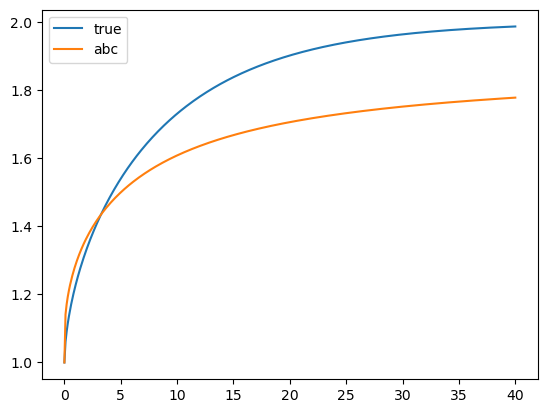

In [72]:
plt.plot(x, corr_true, label = "true")
plt.plot(x, corr_abc, label = "abc")
plt.legend()

In [25]:
get_abc_metrics(test_parameters[i:(i+1)], [r[i:(i+1)], s[i:(i+1)]], model)

RMSE: [3.11 0.05]
Ext - IMSE: 1.3142


# Functional evaluation

In [73]:
i = 20

In [74]:
x = np.linspace(0,40,400)
model = "brown"
corr_true = extremal_coefficient(x, model, test_parameters[i,0], test_parameters[i,1])
corr_abc_mean = abc_ext_func(x, model, r[i], s[i])
corr_param_mean = extremal_coefficient(x, model, r[i].mean(), s[i].mean())
corr_param_lower = extremal_coefficient(x, model, np.quantile(r[i],0.05), np.quantile(s[i],0.05))
corr_param_upper = extremal_coefficient(x, model, np.quantile(r[i],0.95), np.quantile(s[i],0.95))

In [78]:
length = len(r[i])
results = np.zeros(shape = (length, len(x)))
for j in range(length):
    results[j] = extremal_coefficient(x, model, r[i,j], s[i,j])
abc_upper = np.quantile(results, 0.975, axis = 0)
abc_lower = np.quantile(results, 0.025, axis = 0)

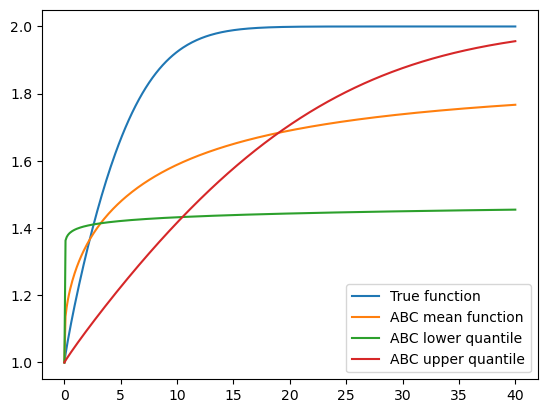

In [59]:
plt.plot(x, corr_true, label = "True function")
plt.plot(x, corr_abc_mean, label = "ABC mean function")
#plt.plot(x, corr_param_mean, label = "ABC mean parameters")
plt.plot(x, corr_param_lower, label = "ABC lower quantile")
plt.plot(x, corr_param_upper, label = "ABC upper quantile")
plt.legend()

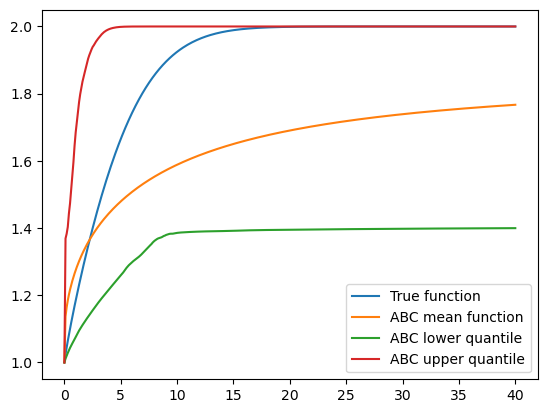

In [79]:
plt.plot(x, corr_true, label = "True function")
plt.plot(x, corr_abc_mean, label = "ABC mean function")
plt.plot(x, abc_lower, label = "ABC lower quantile")
plt.plot(x, abc_upper, label = "ABC upper quantile")
plt.legend()